# TEST DATALOADER 2D DISCRETE

In [1]:
import os
os.chdir('/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src')  # Provide the new path here

In [24]:
from operator import itemgetter

import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray
import fiona

import matplotlib
import matplotlib.pyplot as plt

from rasterio.enums import Resampling
import xarray

from geocube.api.core import make_geocube
from shapely.geometry import box

import json

import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SequentialSampler

from tqdm import tqdm
import time
import wandb
from time import sleep

from models.load_models_2d import *
from dataloaders.load_2d_meteo_wtd import DiscreteDataset

In [3]:
dict_files = {}
with open('/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/configs/discrete_2D_wtd/test_2D_blocks.json') as f:
    dict_files = json.load(f)

print(f"Read data.json: {dict_files}")

ds = DiscreteDataset(dict_files)

timesteps = dict_files["timesteps"]


Read data.json: {'experiment_name': 'first_pinns_test_2D_blocks', 'wandb_dir': '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/runs', 'data_dir': '/leonardo_work/IscrC_DL4EO/trials/data/', 'wtd_csv_path': '/leonardo_work/IscrC_DL4EO/trials/data/dataset_wtd_roi.csv', 'weather_nc_path': '/leonardo_work/IscrC_DL4EO/trials/data/meteo_bucket_model_snowpack_ROI_1958_2023.nc', 'wtd_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/underground_wtd_sensor_roi.shp', 'piedmont_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/piemonte_admin_boundaries.shp', 'dtm_nc': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI.nc', 'timesteps': 180, 'test_split_p': 0.2, 'all_dataset': False, 'max_ds_elems': 1000, 'tensorboard': True, 'dataset': 'wtd_weather_2001_2023', 'input_channels': 10, 'input_height': 9, 'input_width': 12, 'shift_pixels': 0, 'augmentation': True, 'model': 'Discrete2DMidConcatNN', 'start_epoch': 0, 'epochs': 10, 'batch_size': 8, 'optimizer': 'adam', 'lr': 1e-05, 'mi

In [4]:
print(f"Length of the dataset: {ds.__len__()}")

Length of the dataset: 8220


In [5]:
x,y,z = ds[-1]
print(f"Sizes: {x.shape} - {y.shape} - {z.shape}")

Sizes: torch.Size([2, 114, 167]) - torch.Size([10, 180, 9, 12]) - torch.Size([2, 180, 114, 167])


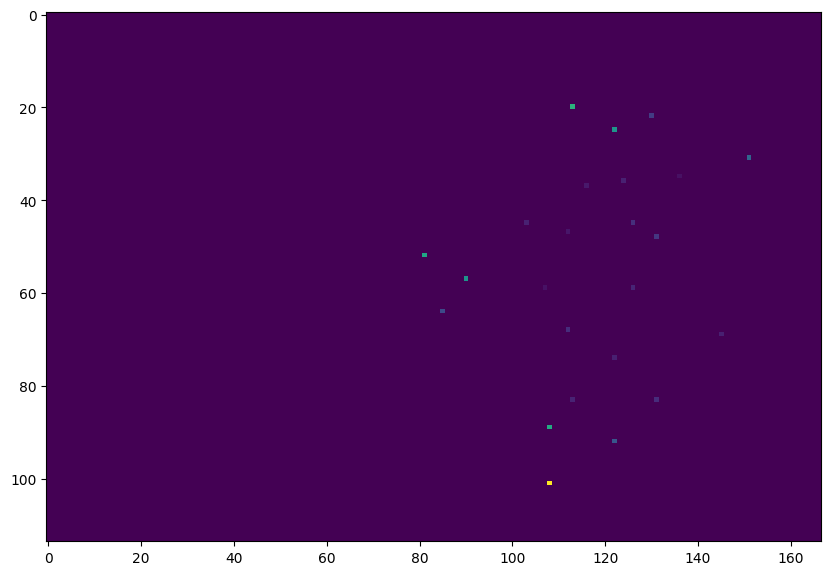

In [6]:
plt.figure(figsize = (10,10))
plt.imshow(x[0,:,:])

In [7]:
ds.dtm_roi_downsampled

<xarray.DataArray '__xarray_dataarray_variable__' (band: 1, y: 114, x: 168)> Size: 77kB
array([[[2899.5454 , 2800.0447 , 2652.8933 , ...,  207.18225,
          203.91689,  200.8909 ],
        [2745.5928 , 2573.3943 , 2378.1335 , ...,  201.14403,
          197.62209,  194.39249],
        [2582.547  , 2200.7563 , 2236.475  , ...,  196.59752,
          194.13895,  190.74823],
        ...,
        [1816.2076 , 2051.5916 , 2158.6135 , ...,  829.5154 ,
          808.9886 ,  741.43695],
        [1769.3004 , 1817.0792 , 1762.4233 , ...,  840.6071 ,
          823.92474,  812.00555],
        [1609.5911 , 1636.23   , 1672.0851 , ...,  833.7745 ,
          827.46497,  753.8922 ]]], dtype=float32)
Coordinates:
  * x            (x) float64 1kB 6.63 6.639 6.647 6.655 ... 8.009 8.017 8.025
  * y            (y) float64 912B 45.26 45.25 45.24 45.24 ... 44.33 44.32 44.31
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    NETCDF_DIM_EXTRA:  {band}
    AREA_OR_POINT:     Area
    scale_factor:      1.0
    add_offset:        0.0
    NETCDF_DIM_band:   1
    _FillValue:        nan

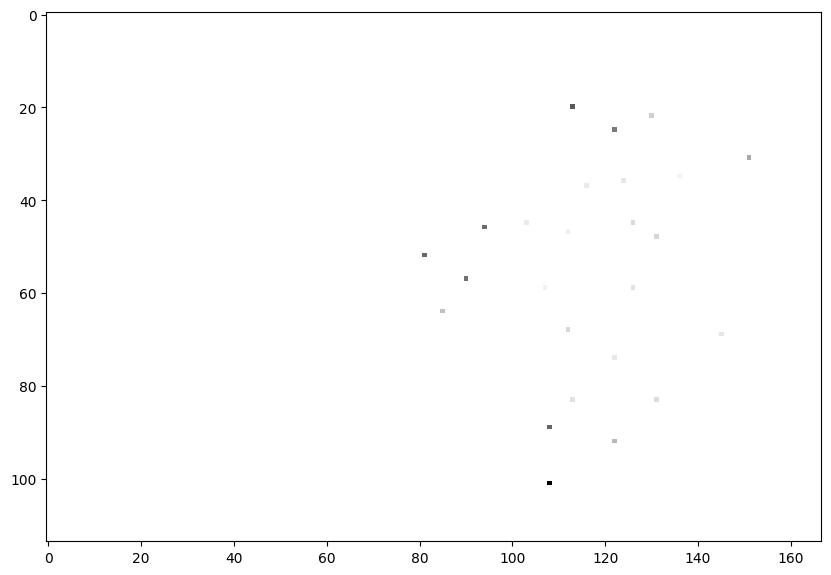

In [8]:
plt.figure(figsize = (10,10))
plt.imshow(ds.wtd_data_raserized["wtd"][-1].values, cmap="binary")

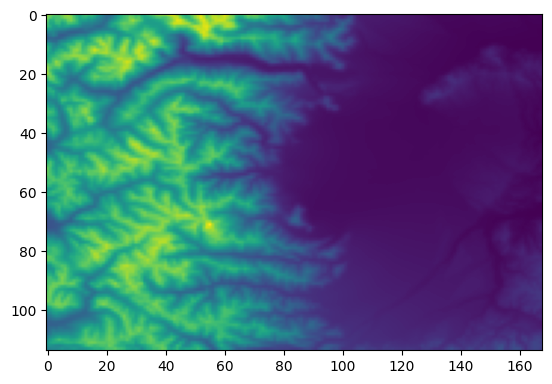

In [9]:
plt.imshow(ds.dtm_roi_downsampled[-1].values)

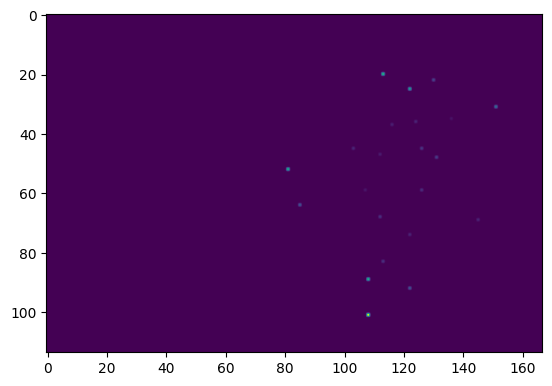

In [10]:
plt.imshow(ds.wtd_data_raserized["wtd"][-90])

In [11]:
input_mask_p = 0.1
output_mask_p = 0.1

nonzero_idxs = np.nonzero(x[:,:,1])
input_mask_m = np.random.uniform(0,1,len(nonzero_idxs)) > input_mask_p
x[nonzero_idxs[:,0],nonzero_idxs[:,1],0] * input_mask_m

/scratch_local/ipykernel_4144666/1532092383.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x[nonzero_idxs[:,0],nonzero_idxs[:,1],0] * input_mask_m


tensor([])

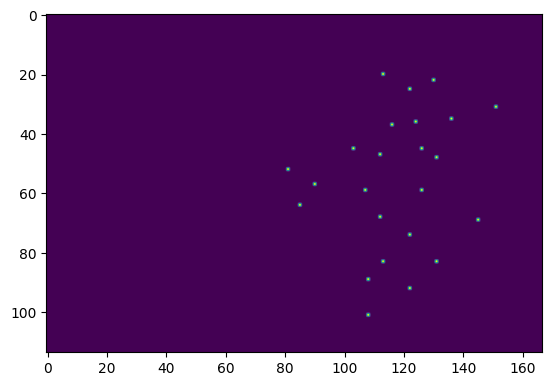

In [12]:
plt.imshow(x[1,:,:])

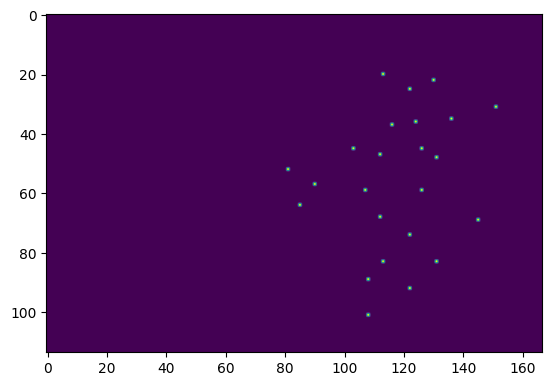

In [13]:
plt.imshow(z[-1,0,:,:])

In [14]:
ds.wtd_data_raserized["wtd"].shape

(8400, 114, 167)

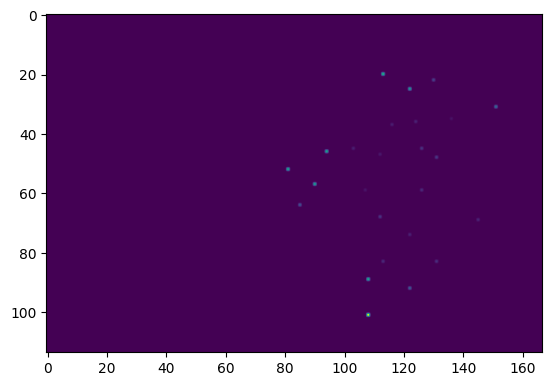

In [ ]:
plt.imshow(ds.wtd_data_raserized["wtd"][-1,:,:])

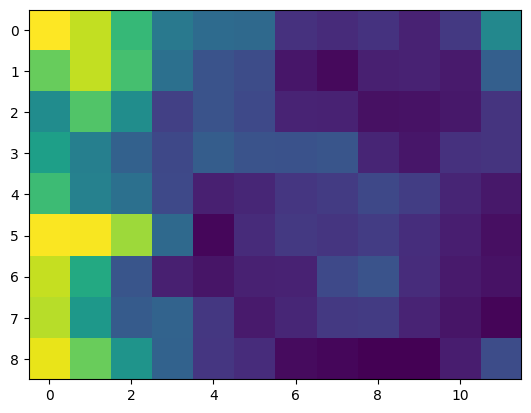

In [16]:
plt.imshow(ds.weather_xr["prec"][-1])

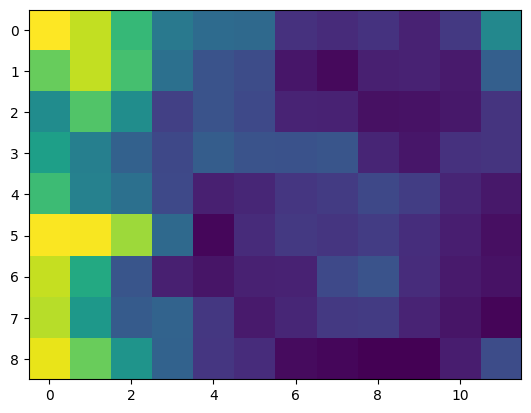

In [17]:
plt.imshow(y[0,-1,:,:])

# TEST DATALOADER

In [18]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [19]:
model = Discrete2DMidConcatNN(timesteps).to(device)

print("Total number of trainable parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

Total number of trainable parameters:  5247


In [20]:
batch_size = dict_files["batch_size"]
max_epochs = dict_files["epochs"]

test_split_p = dict_files["test_split_p"]
train_split_p = 1 - test_split_p

max_ds_elems = ds.__len__()
if not dict_files["all_dataset"]:
    max_ds_elems = dict_files["max_ds_elems"]

train_idx = int(max_ds_elems*train_split_p)
test_idx = int(max_ds_elems*test_split_p)

print(f"Traing size: {train_idx}, Test size: {test_idx}")

train_idxs, test_idxs = np.arange(train_idx), np.arange(train_idx, train_idx + test_idx)

train_sampler = SequentialSampler(train_idxs)
test_sampler = SequentialSampler(test_idxs)

train_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=batch_size,
                                            sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=batch_size,
                                            sampler=test_sampler)

Traing size: 800, Test size: 200


In [21]:
###### BETA ######

input_mask_p = 0.2
output_mask_p = 0.1

def apply_mask(x):
    # TODO: changed dimensions
    nonzero_idxs = np.nonzero(x[:,:,:,1])
    input_mask_m = np.random.uniform(0,1,len(nonzero_idxs)) > input_mask_p
    x[nonzero_idxs[:,0],nonzero_idxs[:,1],nonzero_idxs[:,2],0] = x[nonzero_idxs[:,0],nonzero_idxs[:,1],nonzero_idxs[:,2],0] * input_mask_m
    x[nonzero_idxs[:,0],nonzero_idxs[:,1],nonzero_idxs[:,2],1] = x[nonzero_idxs[:,0],nonzero_idxs[:,1],nonzero_idxs[:,2],1] * input_mask_m

###### BETA ######

In [22]:
###### BETA ######

def loss_masked_v1(y_hat,y):
    print(y_hat.shape)
    print(y.shape)
    # predict = y[:,0,:,:,:].to(device)
    predict = torch.unsqueeze(y[:,0,:,:,:], dim=1).to(device)
    target = y_hat.to(device)
    mask = y[:,1,:,:,:].bool().to(device)
    print(predict.shape)
    print(target.shape)
    print(torch.sum(mask))
    out = torch.sum((torch.masked_select(predict, mask) - torch.masked_select(target, mask))**2.0)  / torch.sum(mask)
    return out

###### BETA ######

In [24]:
def loss_masked(y_hat,y):
    print(y_hat.shape)
    print(y.shape)
    predict = torch.unsqueeze(y[:,0,:,:,:], dim=1).to(device)
    target = y_hat.to(device)
    mask = y[:,1,:,:,:].bool().to(device)

    out = (torch.sum( (predict - target) * mask) ** 2.0 ) / torch.sum(mask)
    return out

In [ ]:
model_file_path = f"{dict_files['save_model_dir']}/"

In [25]:
from tqdm import tqdm
import time

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

X = None
X_masked = None
Y = None

model.train()
start_time = time.time()

for i in range(max_epochs):
    with tqdm(train_loader, unit="batch") as tepoch:
            for batch_idx, (init_wtd, weather, pred_wtds) in enumerate(tepoch):
                tepoch.set_description(f"Epoch {i}")

                X = (init_wtd.to(device), weather.to(device))
                Y = model(X)
                loss = loss_masked(Y,pred_wtds)
                print(loss)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                
                
end_time = time.time()

Epoch 0:   0%|          | 0/50 [00:00<?, ?batch/s]

torch.Size([16, 1, 180, 114, 167])
torch.Size([16, 2, 180, 114, 167])
tensor(1.5713e+09, grad_fn=<DivBackward0>)


Epoch 0:   2%|▏         | 1/50 [00:23<18:18, 22.43s/batch]

torch.Size([16, 1, 180, 114, 167])
torch.Size([16, 2, 180, 114, 167])
tensor(1.5230e+09, grad_fn=<DivBackward0>)


Epoch 0:   2%|▏         | 1/50 [00:47<38:23, 47.02s/batch]


KeyboardInterrupt: 

In [21]:
x1,y1,z1 = ds[0]
print(f"Sizes: {x1.shape} - {y1.shape} - {z1.shape}")

Sizes: torch.Size([2, 114, 167]) - torch.Size([10, 180, 9, 12]) - torch.Size([2, 180, 114, 167])


In [26]:
model = Discrete2DMidConcatNN()
model.load_state_dict(torch.load("/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/model_test.pt", weights_only=True, map_location=torch.device('cpu')))
model.eval()

Discrete2DMidConcatNN(
  (m_conv_1): ConvBlock(
    (block): Sequential(
      (0): Conv3d(2, 2, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=same)
      (1): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv3d(2, 2, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=same)
      (4): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    )
  )
  (m_avg_pool_2): AdaptiveMaxPool3d(output_size=(None, 72, 96))
  (m_conv_tr_1): ConvTBlock(
    (block): Sequential(
      (0): ConvTranspose3d(10, 10, kernel_size=(1, 3, 3), stride=(1, 3, 3))
      (1): BatchNorm3d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv3d(10, 10, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=same)
      (4): BatchNorm3d(10, eps=1e-05, momentum=0.1, affin

In [27]:
X = (torch.unsqueeze(x1, dim=0).to(device), torch.unsqueeze(y1, dim=0).to(device))
Y = model(X)
print(Y)
print(Y.shape)

tensor([[[[[2.1806e-01, 2.6694e-01, 4.6096e-02,  ..., 2.6994e-01,
            0.0000e+00, 2.7842e-01],
           [6.6589e-01, 2.9885e-01, 0.0000e+00,  ..., 6.9227e-01,
            0.0000e+00, 0.0000e+00],
           [5.8809e-01, 0.0000e+00, 0.0000e+00,  ..., 5.8903e-01,
            1.9977e-01, 8.3910e-02],
           ...,
           [7.6200e-01, 1.3691e-01, 1.6000e-01,  ..., 5.5853e-01,
            2.3166e-01, 3.7087e-02],
           [5.1482e-01, 0.0000e+00, 6.4688e-02,  ..., 5.5674e-01,
            1.1628e-01, 3.4818e-01],
           [8.5268e-01, 2.6503e-01, 2.1804e-01,  ..., 6.9937e-01,
            2.3345e-01, 4.8966e-01]],

          [[2.0184e-01, 2.5220e-01, 3.3343e-02,  ..., 2.7295e-01,
            0.0000e+00, 2.7360e-01],
           [6.6598e-01, 3.0805e-01, 0.0000e+00,  ..., 7.0053e-01,
            0.0000e+00, 0.0000e+00],
           [5.7571e-01, 0.0000e+00, 0.0000e+00,  ..., 5.3695e-01,
            2.2641e-01, 7.6927e-02],
           ...,
           [7.1591e-01, 2.0889e-01, 2.8

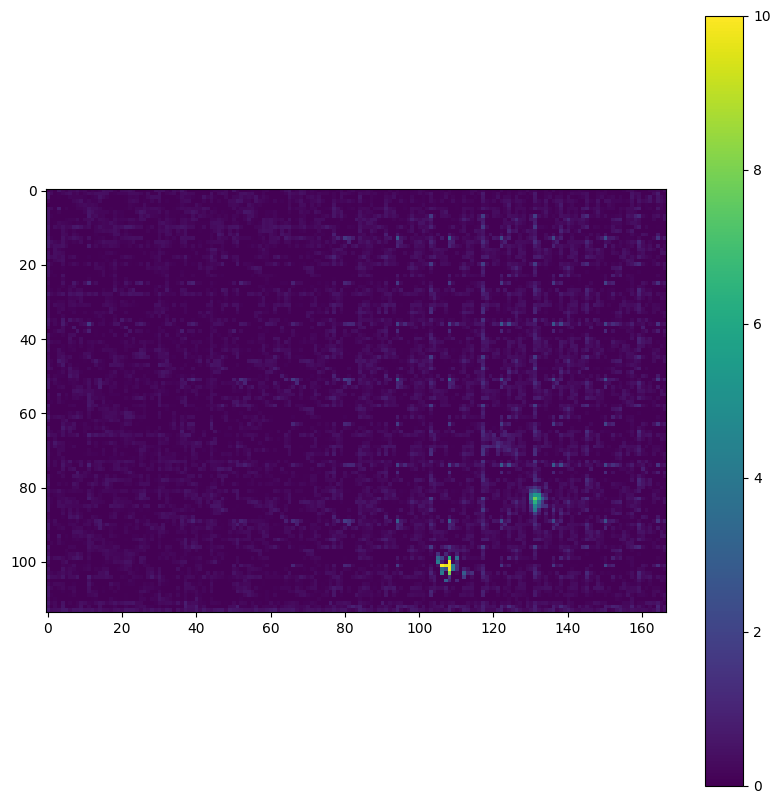

In [32]:
with torch.no_grad():
    plt.figure(figsize = (10,10))
    plt.imshow(Y[0,0,10,:,:], vmax=10)
    plt.colorbar()

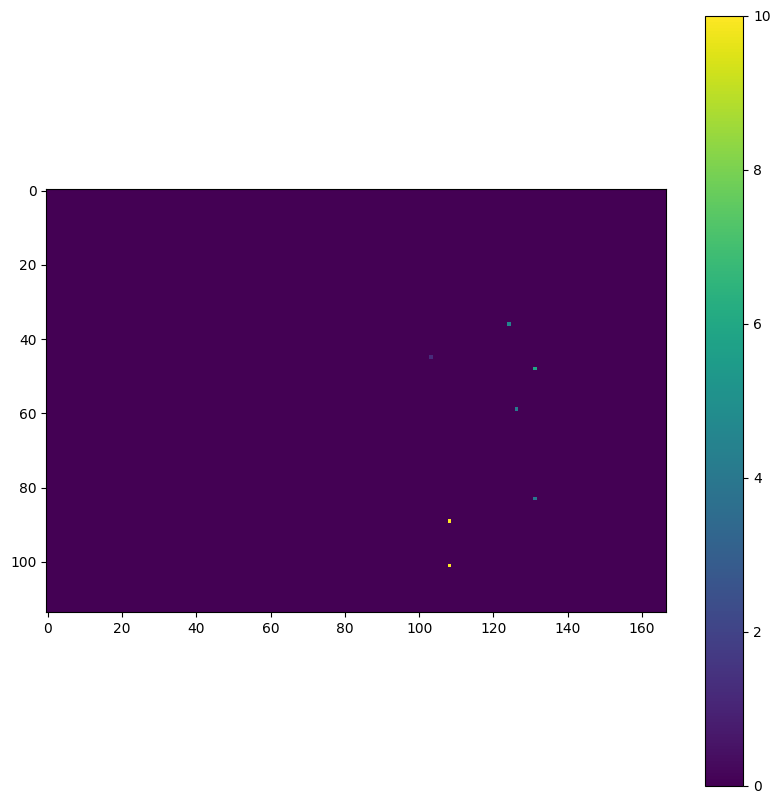

In [33]:
plt.figure(figsize = (10,10))
plt.imshow(z1[0,10,:,:],  vmax=10)
plt.colorbar()